# Cortical layer markers

This notebook checks the expression of (putative) cortical layer markers across our rough subregion clustering. It also generates spatial visualizations of the MERFISH data to compare to Allen Brain Atlas ISH images.

**Associated manuscript figures/tables:**
- Extended Data Figures: 3b,c,d


**Inputs required:**
- `data/integrated_aging_coronal_celltyped_regioned_raw.h5ad` - AnnData object for coronal section dataset

**Conda environment used**: `requirements/merfish.txt`

In [1]:
import scanpy as sc
import squidpy as sq
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import seaborn as sns
import anndata as ad
import os
from scipy.stats import pearsonr, spearmanr

from clock_preprocessing import normalize_adata

In [2]:
region_fine_palette = {"CTX_L1/MEN":"darkorange",
                       "CTX_L2/3":"bisque",
                       "CTX_L4/5/6": "tan",
                       'STR_CP/ACB': "darkgreen",
                       'STR_LS/NDB': "limegreen",
                        'VEN': 'r',
                       'CC/ACO': 'b'}

region_coarse_palette = {"CTX":"darkorange",
                       'STR': "lightgreen",
                        'VEN': 'r',
                       'CC/ACO': 'b'}

regions_ordered = ['CTX_L1/MEN', 'CTX_L2/3', 'CTX_L4/5/6', 'STR_CP/ACB', 'STR_LS/NDB', 'CC/ACO', 'VEN']

In [3]:
adata = sc.read_h5ad("data/integrated_aging_coronal_celltyped_regioned_raw.h5ad")

adata.obs["region"] = adata.obs["region"].astype('category').cat.reorder_categories(regions_ordered)

adata = normalize_adata(adata, zscore=False)

# define coarse regions
coarse_region_mapping = {
    "CC/ACO":"CC/ACO",
    "CTX_L1/MEN":"CTX",
    "CTX_L2/3":"CTX",
    "CTX_L4/5/6":"CTX",
    "STR_CP/ACB":"STR",
    "STR_LS/NDB":"STR",
    "VEN":"VEN",
}

adata.obs["region_coarse"] = [coarse_region_mapping[x] for x in adata.obs.region]
adata.obs["region_coarse"] = adata.obs["region_coarse"].astype('category').cat.reorder_categories(["CTX","STR","CC/ACO","VEN"])

In [4]:
markers = ["Reln", "Lamp5", "Vip", "Sst", "Pvalb"]

adata = adata[:,markers]

## Violin plots of cortical marker expression

 - Reln -- a well known L1 marker


 - Lamp5, Vip, Sst, Pvalb -- not cortical layer markers but have differences in depth (Zhang et al., 2021)
    - See Figure 1: https://www.nature.com/articles/s41586-021-03705-x

In [5]:
adata = adata[adata.obs.region_coarse=="CTX"]

In [6]:
# make df
df = pd.DataFrame(adata.X, columns=markers, index=adata.obs_names)
df = df.join(adata.obs,how='inner')
df = df[["mouse_id","region"]+markers]

In [7]:
avg_df = df.groupby(["mouse_id","region"]).mean().reset_index()

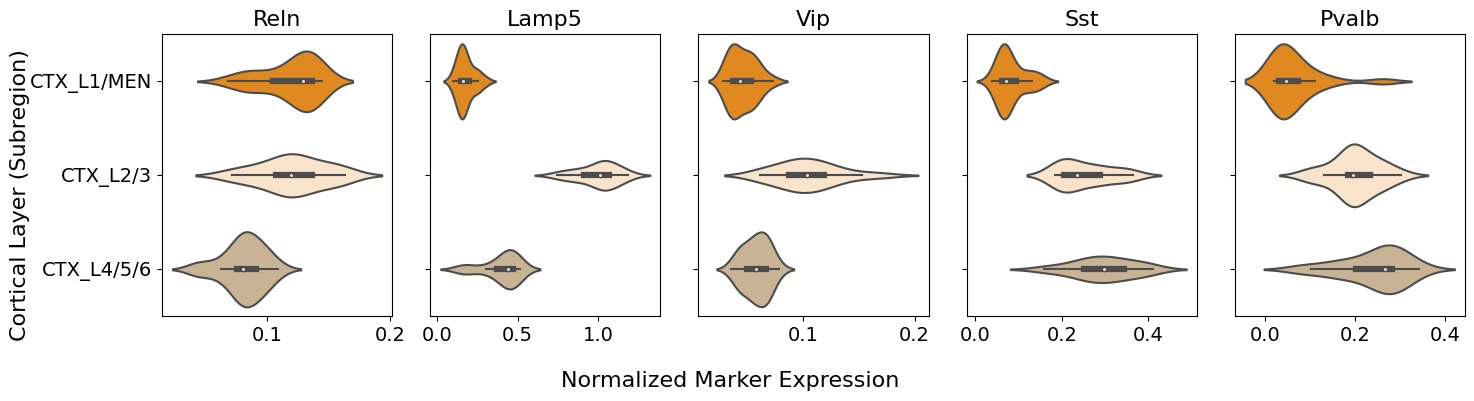

In [8]:
ncols = len(markers)

# make boxplots to show distribution of metrics
fig, axs = plt.subplots(1, ncols, figsize=(15,4), sharex=False, sharey=True)

for i, marker in enumerate(markers):
    sns.violinplot(avg_df, x=marker, y="region", orient='h', palette=region_fine_palette,
                   ax=axs[i])
    axs[i].set_title(marker, fontsize=16)
    axs[i].set_xlabel("")
    axs[i].set_ylabel("")
    axs[i].tick_params(axis='both',labelsize=14)

fig.supxlabel("Log-Normalized Marker Expression", fontsize=16)
fig.supylabel("Cortical Layer (Subregion)", fontsize=16)
fig.tight_layout()
plt.savefig(f"plots/QC/cortical_layers_markers.pdf", bbox_inches='tight')
plt.show()

## MERFISH spatial visualizations of markers and subregions

In [ ]:
age = 34.5

fig, ax = plt.subplots(1, 1, figsize=(7,5))
sc.set_figure_params(dpi=500)

curr_adata = adata[adata.obs.age==age].copy()
sc.pl.embedding(curr_adata, "spatial", color="region_coarse", s=3, show=False,
               ax=ax, legend_fontsize=18, palette=region_coarse_palette)
plt.title("", fontsize=18)
plt.axis('off')
plt.savefig("plots/clustering/spatial_celltype_region.pdf", bbox_inches='tight')
plt.show()

In [ ]:
age = 34.5

fig, ax = plt.subplots(1, 1, figsize=(7,5))
sc.set_figure_params(dpi=500)

curr_adata = adata[adata.obs.age==age].copy()
sc.pl.embedding(curr_adata, "spatial", color="region", s=3, show=False,
               ax=ax, legend_fontsize=18, palette=region_fine_palette)
plt.title("", fontsize=18)
plt.axis('off')
plt.savefig("plots/clustering/spatial_celltype_subregion.pdf", bbox_inches='tight')
plt.show()

In [ ]:
for i, marker in enumerate(markers):

    age = 34.5

    fig, ax = plt.subplots(1, 1, figsize=(6.5,5))
    sc.set_figure_params(dpi=500)

    curr_adata = adata[adata.obs.age==age].copy()
    sc.pl.embedding(curr_adata, "spatial", color=marker, s=3, show=False,
                   ax=ax, colorbar_loc=None, cmap="Reds")
    plt.title(marker, fontsize=36)
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(f"plots/clustering/spatial_celltype_{marker}.pdf", bbox_inches='tight')
    plt.show()